In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [28]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [29]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [30]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [31]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
#for param in vgg16.features.parameters():
#   param.requires_grad = False
print(vgg16.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [32]:
class FCN16(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN16, self).__init__()
        self.vgg16 = vgg16.features

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=1)
        self.fc2 = nn.Conv2d(4096,4096,kernel_size=1)
        self.fc3 = nn.Conv2d(4096,num_class,kernel_size=1)
        self.pool4_conv = nn.Conv2d(512,21,kernel_size=1)

        self.upsample2 = nn.ConvTranspose2d(num_class, num_class,2,2,bias=False)
        self.upsample16 = nn.ConvTranspose2d(num_class,num_class,16,16,bias=False)
        # self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn2     = nn.BatchNorm2d(256)
        # self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn3     = nn.BatchNorm2d(128)
        # self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn4     = nn.BatchNorm2d(64)
        # self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn5     = nn.BatchNorm2d(32)
        # self.classifier = nn.Conv2d(32, num_class, kernel_size=1)
        # self.relu    = nn.ReLU(inplace=True)
        #self._initialize_weights()
    def forward(self, x):
        pool4 = self.vgg16[:-7](x)
        pool5 = self.vgg16[-7:](pool4)

        #print(pool5.shape)
        pool5 = self.fc1(pool5)
        #print(pool5.shape)
        pool5 = nn.ReLU(True)(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc2(pool5)
        pool5 = nn.ReLU(True)(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc3(pool5)

        pool5 = self.upsample2(pool5)
        pool4 = self.pool4_conv(pool4)
        x = pool5 + pool4
        x = self.upsample16(x)
        # print(pool5.shape)
        # print(pool4.shape)
        
        # pool5 = self.deconv1(pool5)
        # #print(pool5.shape)
        # #print(pool4.shape)
        # x = pool5 + pool4
        # x = self.relu(self.deconv2(x))
        # x = self.bn2(x)
        # x = self.relu(self.deconv3(x))
        # x = self.bn3(x)
        # x = self.relu(self.deconv4(x))
        # x = self.bn4(x)
        # x = self.relu(self.deconv5(x))
        # x = self.bn5(x)
        # x = self.classifier(x)
        #print(x.shape)
        #print(x.shape)
        #x = self.upsample16(x)
        #print(x.shape)
        return x
    # def _initialize_weights(self):
    #         for m in self.modules():
    #             if isinstance(m, nn.Conv2d):
    #                 m.weight.data.zero_()
    #                 if m.bias is not None:
    #                     m.bias.data.zero_()
    # def make_block(self, in_channel, out_channel, repeat):
    #     layers = []
    #     for i in range(repeat):
    #         if (i==0):
    #             layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
    #         else:
    #             layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
    #         layers.append(nn.BatchNorm2d(out_channel))
    #         layers.append(nn.ReLU())
    #     layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    #     block = nn.Sequential(*layers)

    #     return block

In [33]:
FCN =FCN16(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792           1,792
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928          36,928
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856          73,856
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584         147,584
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.00007)

In [35]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [36]:
# 학습
FCN.to(device)
epochs= 50
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_miou = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_miou < val_iou_score:
            min_miou = val_iou_score
            #print('save model')
            torch.save(FCN, './models/FCN16-Vgg16.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:27, 13.10it/s]
363it [00:18, 19.71it/s]


1 epcoh , time = 46.38
train loss : 1.27231, val_loss : 1.02985
train IoU : 0.12760, val IoU : 0.15782
train Acc : 0.70007, val Acc : 0.75482


366it [00:28, 13.00it/s]
363it [00:18, 19.95it/s]


2 epcoh , time = 46.35
train loss : 0.94403, val_loss : 0.87773
train IoU : 0.18906, val IoU : 0.21444
train Acc : 0.76868, val Acc : 0.77456


366it [00:28, 12.87it/s]
363it [00:18, 19.26it/s]


3 epcoh , time = 47.30
train loss : 0.83161, val_loss : 0.81908
train IoU : 0.22499, val IoU : 0.23297
train Acc : 0.78534, val Acc : 0.78242


366it [00:28, 12.69it/s]
363it [00:19, 18.68it/s]


4 epcoh , time = 48.28
train loss : 0.75833, val_loss : 0.76942
train IoU : 0.25288, val IoU : 0.26039
train Acc : 0.79667, val Acc : 0.78752


366it [00:29, 12.55it/s]
363it [00:18, 19.82it/s]


5 epcoh , time = 47.49
train loss : 0.69663, val_loss : 0.82421
train IoU : 0.27913, val IoU : 0.23930
train Acc : 0.80622, val Acc : 0.78058


366it [00:28, 12.94it/s]
363it [00:18, 19.62it/s]


6 epcoh , time = 46.79
train loss : 0.64877, val_loss : 0.72653
train IoU : 0.30296, val IoU : 0.29641
train Acc : 0.81285, val Acc : 0.79801


366it [00:28, 12.90it/s]
363it [00:19, 19.06it/s]


7 epcoh , time = 47.41
train loss : 0.58805, val_loss : 0.70686
train IoU : 0.32668, val IoU : 0.28665
train Acc : 0.82312, val Acc : 0.80141


366it [00:28, 12.66it/s]
363it [00:19, 18.64it/s]


8 epcoh , time = 48.40
train loss : 0.53202, val_loss : 0.77187
train IoU : 0.35936, val IoU : 0.30801
train Acc : 0.83539, val Acc : 0.78589


366it [00:29, 12.58it/s]
363it [00:18, 19.62it/s]


9 epcoh , time = 47.60
train loss : 0.49108, val_loss : 0.67979
train IoU : 0.39198, val IoU : 0.34008
train Acc : 0.84463, val Acc : 0.81683


366it [00:28, 13.04it/s]
363it [00:18, 19.84it/s]


10 epcoh , time = 46.37
train loss : 0.43406, val_loss : 0.68239
train IoU : 0.43159, val IoU : 0.36444
train Acc : 0.86111, val Acc : 0.81306


366it [00:27, 13.09it/s]
363it [00:18, 19.89it/s]


11 epcoh , time = 46.22
train loss : 0.38037, val_loss : 0.70325
train IoU : 0.48218, val IoU : 0.36159
train Acc : 0.87706, val Acc : 0.81007


366it [00:27, 13.08it/s]
363it [00:18, 19.53it/s]


12 epcoh , time = 46.57
train loss : 0.36976, val_loss : 0.65113
train IoU : 0.49849, val IoU : 0.38570
train Acc : 0.88395, val Acc : 0.82144


366it [00:28, 12.99it/s]
363it [00:18, 19.70it/s]


13 epcoh , time = 46.60
train loss : 0.31288, val_loss : 0.68933
train IoU : 0.53694, val IoU : 0.40343
train Acc : 0.89917, val Acc : 0.81847


366it [00:28, 12.79it/s]
363it [00:18, 19.49it/s]


14 epcoh , time = 47.24
train loss : 0.26864, val_loss : 0.75064
train IoU : 0.57647, val IoU : 0.39056
train Acc : 0.91275, val Acc : 0.82219


366it [00:28, 12.94it/s]
363it [00:18, 19.27it/s]


15 epcoh , time = 47.14
train loss : 0.26138, val_loss : 0.72593
train IoU : 0.58214, val IoU : 0.40419
train Acc : 0.91490, val Acc : 0.83292


366it [00:28, 12.81it/s]
363it [00:18, 19.92it/s]


16 epcoh , time = 46.81
train loss : 0.21229, val_loss : 0.77772
train IoU : 0.62486, val IoU : 0.40697
train Acc : 0.93010, val Acc : 0.82694


366it [00:28, 12.96it/s]
363it [00:18, 19.33it/s]


17 epcoh , time = 47.03
train loss : 0.21266, val_loss : 0.70166
train IoU : 0.62872, val IoU : 0.43711
train Acc : 0.92993, val Acc : 0.82628


366it [00:28, 12.75it/s]
363it [00:18, 19.43it/s]


18 epcoh , time = 47.39
train loss : 0.17636, val_loss : 0.71387
train IoU : 0.66464, val IoU : 0.44139
train Acc : 0.94145, val Acc : 0.83725


366it [00:27, 13.07it/s]
363it [00:18, 19.25it/s]


19 epcoh , time = 46.86
train loss : 0.20153, val_loss : 0.87574
train IoU : 0.64867, val IoU : 0.33037
train Acc : 0.93417, val Acc : 0.80081


366it [00:28, 12.77it/s]
363it [00:18, 19.58it/s]


20 epcoh , time = 47.22
train loss : 0.20502, val_loss : 0.75744
train IoU : 0.63915, val IoU : 0.42612
train Acc : 0.93311, val Acc : 0.83626


366it [00:28, 12.73it/s]
363it [00:18, 19.46it/s]


21 epcoh , time = 47.41
train loss : 0.14281, val_loss : 0.73993
train IoU : 0.70546, val IoU : 0.43891
train Acc : 0.95196, val Acc : 0.83481


366it [00:28, 12.99it/s]
363it [00:18, 19.88it/s]


22 epcoh , time = 46.44
train loss : 0.13666, val_loss : 0.80397
train IoU : 0.71367, val IoU : 0.42525
train Acc : 0.95331, val Acc : 0.84104


366it [00:29, 12.58it/s]
363it [00:19, 19.00it/s]


23 epcoh , time = 48.22
train loss : 0.12406, val_loss : 0.79593
train IoU : 0.72778, val IoU : 0.43673
train Acc : 0.95715, val Acc : 0.84047


366it [00:28, 12.91it/s]
363it [00:18, 19.58it/s]


24 epcoh , time = 46.90
train loss : 0.19475, val_loss : 0.73049
train IoU : 0.66813, val IoU : 0.39042
train Acc : 0.93683, val Acc : 0.81744


366it [00:28, 12.89it/s]
363it [00:18, 19.78it/s]


25 epcoh , time = 46.74
train loss : 0.15766, val_loss : 0.88140
train IoU : 0.69533, val IoU : 0.39077
train Acc : 0.94759, val Acc : 0.82323


366it [00:28, 12.91it/s]
363it [00:18, 19.60it/s]


26 epcoh , time = 46.88
train loss : 0.15628, val_loss : 0.78695
train IoU : 0.69572, val IoU : 0.44454
train Acc : 0.94799, val Acc : 0.84148


366it [00:28, 12.82it/s]
363it [00:18, 19.56it/s]


27 epcoh , time = 47.12
train loss : 0.10775, val_loss : 0.84650
train IoU : 0.75043, val IoU : 0.41201
train Acc : 0.96170, val Acc : 0.83739


366it [00:28, 12.91it/s]
363it [00:18, 19.46it/s]


28 epcoh , time = 47.02
train loss : 0.10081, val_loss : 0.77718
train IoU : 0.76017, val IoU : 0.45739
train Acc : 0.96378, val Acc : 0.83903


366it [00:28, 12.77it/s]
363it [00:18, 19.43it/s]


29 epcoh , time = 47.35
train loss : 0.09466, val_loss : 0.84317
train IoU : 0.76963, val IoU : 0.44482
train Acc : 0.96551, val Acc : 0.84408


366it [00:29, 12.60it/s]
363it [00:18, 19.25it/s]


30 epcoh , time = 47.92
train loss : 0.09279, val_loss : 0.85077
train IoU : 0.77191, val IoU : 0.44300
train Acc : 0.96580, val Acc : 0.84444


366it [00:29, 12.62it/s]
363it [00:19, 18.96it/s]


31 epcoh , time = 48.16
train loss : 0.09415, val_loss : 0.85873
train IoU : 0.77122, val IoU : 0.44255
train Acc : 0.96542, val Acc : 0.84573


366it [00:28, 12.72it/s]
363it [00:19, 19.06it/s]


32 epcoh , time = 47.81
train loss : 0.23716, val_loss : 0.79782
train IoU : 0.63733, val IoU : 0.42528
train Acc : 0.92468, val Acc : 0.83719


366it [00:29, 12.57it/s]
363it [00:18, 19.67it/s]


33 epcoh , time = 47.59
train loss : 0.11140, val_loss : 0.81843
train IoU : 0.74863, val IoU : 0.43326
train Acc : 0.96049, val Acc : 0.84305


366it [00:28, 12.88it/s]
363it [00:18, 19.81it/s]


34 epcoh , time = 46.75
train loss : 0.09282, val_loss : 0.82883
train IoU : 0.76812, val IoU : 0.44567
train Acc : 0.96598, val Acc : 0.84451


366it [00:28, 12.83it/s]
363it [00:18, 19.74it/s]


35 epcoh , time = 46.93
train loss : 0.13493, val_loss : 0.79603
train IoU : 0.73712, val IoU : 0.44118
train Acc : 0.95366, val Acc : 0.83857


366it [00:28, 12.84it/s]
363it [00:18, 19.39it/s]


36 epcoh , time = 47.23
train loss : 0.09426, val_loss : 0.85920
train IoU : 0.77399, val IoU : 0.44146
train Acc : 0.96554, val Acc : 0.84007


366it [00:28, 12.91it/s]
363it [00:18, 19.78it/s]


37 epcoh , time = 46.71
train loss : 0.08085, val_loss : 0.84158
train IoU : 0.79128, val IoU : 0.45078
train Acc : 0.96957, val Acc : 0.84683


366it [00:28, 12.90it/s]
363it [00:19, 19.05it/s]


38 epcoh , time = 47.44
train loss : 0.07706, val_loss : 0.83431
train IoU : 0.79412, val IoU : 0.45496
train Acc : 0.97070, val Acc : 0.84756


366it [00:28, 12.86it/s]
363it [00:18, 19.33it/s]


39 epcoh , time = 47.24
train loss : 0.07594, val_loss : 0.81390
train IoU : 0.79906, val IoU : 0.46420
train Acc : 0.97098, val Acc : 0.84373


366it [00:28, 12.74it/s]
363it [00:18, 19.82it/s]


40 epcoh , time = 47.06
train loss : 0.07643, val_loss : 0.89237
train IoU : 0.79778, val IoU : 0.44494
train Acc : 0.97080, val Acc : 0.84775


366it [00:28, 12.88it/s]
363it [00:18, 19.19it/s]


41 epcoh , time = 47.33
train loss : 0.18315, val_loss : 0.79473
train IoU : 0.70519, val IoU : 0.39660
train Acc : 0.94278, val Acc : 0.81308


366it [00:28, 12.73it/s]
363it [00:18, 19.60it/s]


42 epcoh , time = 47.27
train loss : 0.14166, val_loss : 0.94550
train IoU : 0.72107, val IoU : 0.41799
train Acc : 0.95152, val Acc : 0.83418


366it [00:28, 13.03it/s]
363it [00:18, 19.28it/s]


43 epcoh , time = 46.92
train loss : 0.09272, val_loss : 0.84742
train IoU : 0.77509, val IoU : 0.44880
train Acc : 0.96582, val Acc : 0.84444


366it [00:28, 12.80it/s]
363it [00:18, 19.62it/s]


44 epcoh , time = 47.10
train loss : 0.07384, val_loss : 0.87122
train IoU : 0.80495, val IoU : 0.45843
train Acc : 0.97170, val Acc : 0.85002


366it [00:28, 12.78it/s]
363it [00:18, 19.58it/s]


45 epcoh , time = 47.19
train loss : 0.06950, val_loss : 0.84950
train IoU : 0.81015, val IoU : 0.45758
train Acc : 0.97304, val Acc : 0.84819


366it [00:28, 12.87it/s]
363it [00:18, 19.65it/s]


46 epcoh , time = 46.91
train loss : 0.06818, val_loss : 0.89757
train IoU : 0.81119, val IoU : 0.45773
train Acc : 0.97352, val Acc : 0.84951


366it [00:28, 12.75it/s]
363it [00:18, 19.53it/s]


47 epcoh , time = 47.30
train loss : 0.06713, val_loss : 0.92864
train IoU : 0.80976, val IoU : 0.45231
train Acc : 0.97388, val Acc : 0.84840


366it [00:28, 12.76it/s]
363it [00:18, 19.22it/s]


48 epcoh , time = 47.57
train loss : 0.06680, val_loss : 0.89143
train IoU : 0.81246, val IoU : 0.45656
train Acc : 0.97395, val Acc : 0.84876


366it [00:28, 12.75it/s]
363it [00:19, 18.61it/s]


49 epcoh , time = 48.22
train loss : 0.06731, val_loss : 0.89688
train IoU : 0.81376, val IoU : 0.45031
train Acc : 0.97380, val Acc : 0.84705


366it [00:28, 12.66it/s]
363it [00:18, 19.49it/s]

50 epcoh , time = 47.55
train loss : 0.23601, val_loss : 0.76413
train IoU : 0.66172, val IoU : 0.42497
train Acc : 0.92763, val Acc : 0.82093
Finish Training


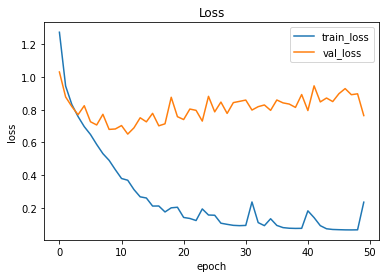

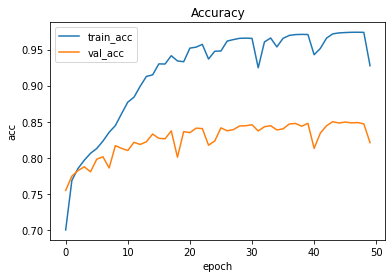

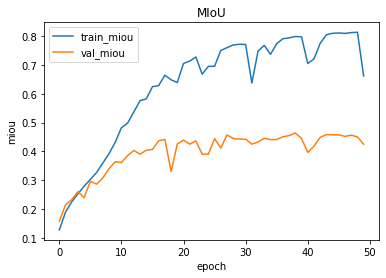

In [44]:

history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [46]:
best=torch.load('./models/FCN16-Vgg16.pt')

In [47]:
def decode_segmap(image, num_class=21):
    label_color = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_class):
        idx = image==l
        r[idx] = label_color[l,0]
        g[idx] = label_color[l,1]
        b[idx] = label_color[l,2]
    rgb =np.stack([r,g,b], axis=2)
    return rgb

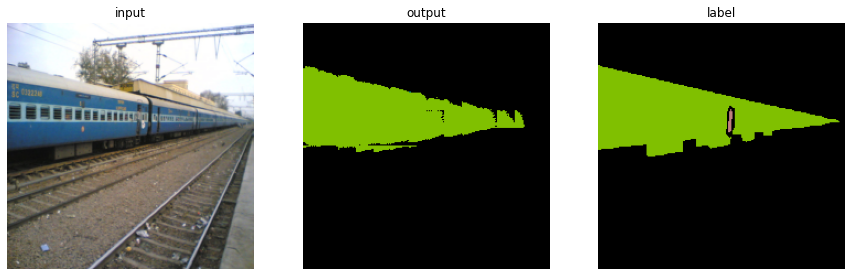

In [56]:
#img, label= train_set[0]
best.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        img, label = data
        
        best.to(device)
        #print(f'input shape:',img.shape)
        img = img.to(device)
        output = best(img)

        # tensor의 추적 제거 detach
        pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        pred = decode_segmap(pred,21)
        
        img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
        img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
        img = img[0].detach().cpu().numpy()
        img = img.transpose(1,2,0)

        label = label[0].detach().cpu().numpy()
        label = decode_segmap(label,21)

        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.title('input')
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('output')
        plt.axis('off')
        plt.imshow(pred)
        plt.subplot(1,3,3)
        plt.title('label')
        plt.axis('off')
        plt.imshow(label)
        break


torch.Size([1, 3, 224, 224])


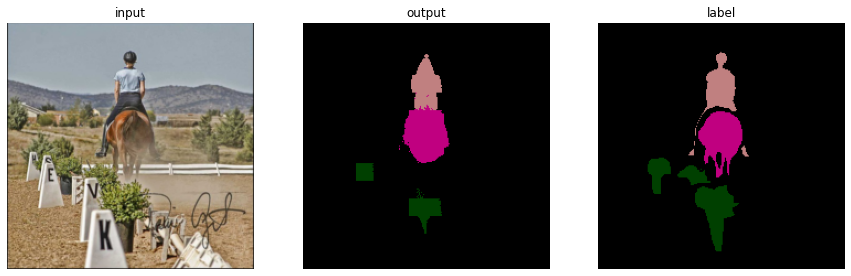

In [53]:
img, label= train_set[10]
best.eval()
#img = transform(img)
#label = val_transform(label)
best.to(device)
img=img.to(device)
label = label.to(device)
with torch.no_grad():
    
    img = img.unsqueeze(0)
    label = label.unsqueeze(0)
    output = best(img)
    pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        
    pred = decode_segmap(pred,21)
    print(img.shape)
    img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
    img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
    img = img.detach().cpu().numpy()
    img = img.transpose(1,2,0)
    label = label[0].detach().cpu().numpy()
    label = decode_segmap(label,21)
    
    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.title('input')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('output')
    plt.axis('off')
    plt.imshow(pred)
    plt.subplot(1,3,3)
    plt.title('label')
    plt.axis('off')
    plt.imshow(label)
    #break